In [ ]:
'''

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/ENEL645/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

In [ ]:
#dataset download and unzipping
#download the dataset from google drive
!wget --no-check-certificate -O '/content/chest_xray_data.zip' 'https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded'
#create a directory for the data
!mkdir -p data
#unzipping the downladed file to get the images 
!unzip -q -n '/content/chest_xray_data.zip' -d '/content/data/chest_xray_data' 

--2023-03-17 05:31:44--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/e9a18c27-67da-40a2-8f48-1c12f03de39d [following]
--2023-03-17 05:31:45--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/e9a18c27-67da-40a2-8f48-1c12f03de39d
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.25.112, 52.218.44.218, 52.218.110.72, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.25.112|

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt   
import matplotlib.image as mpimg 
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
#seed(42)

#random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tensorflow.random import set_seed
#set_seed(42)

import warnings
warnings.filterwarnings('ignore')
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC, Accuracy, Precision, SensitivityAtSpecificity
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
#main_path = "/content/data/chest_xray_data/CellData/chest_xray"
#main_path = "G:/My Drive/datasets/xray-pneumonia/chest_xray/chest_xray/"
main_path = "C:/Users/nourn/Desktop/post_grad/winter/machine learning/project/pnemonia/code/data/chest_xray/chest_xray/"
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

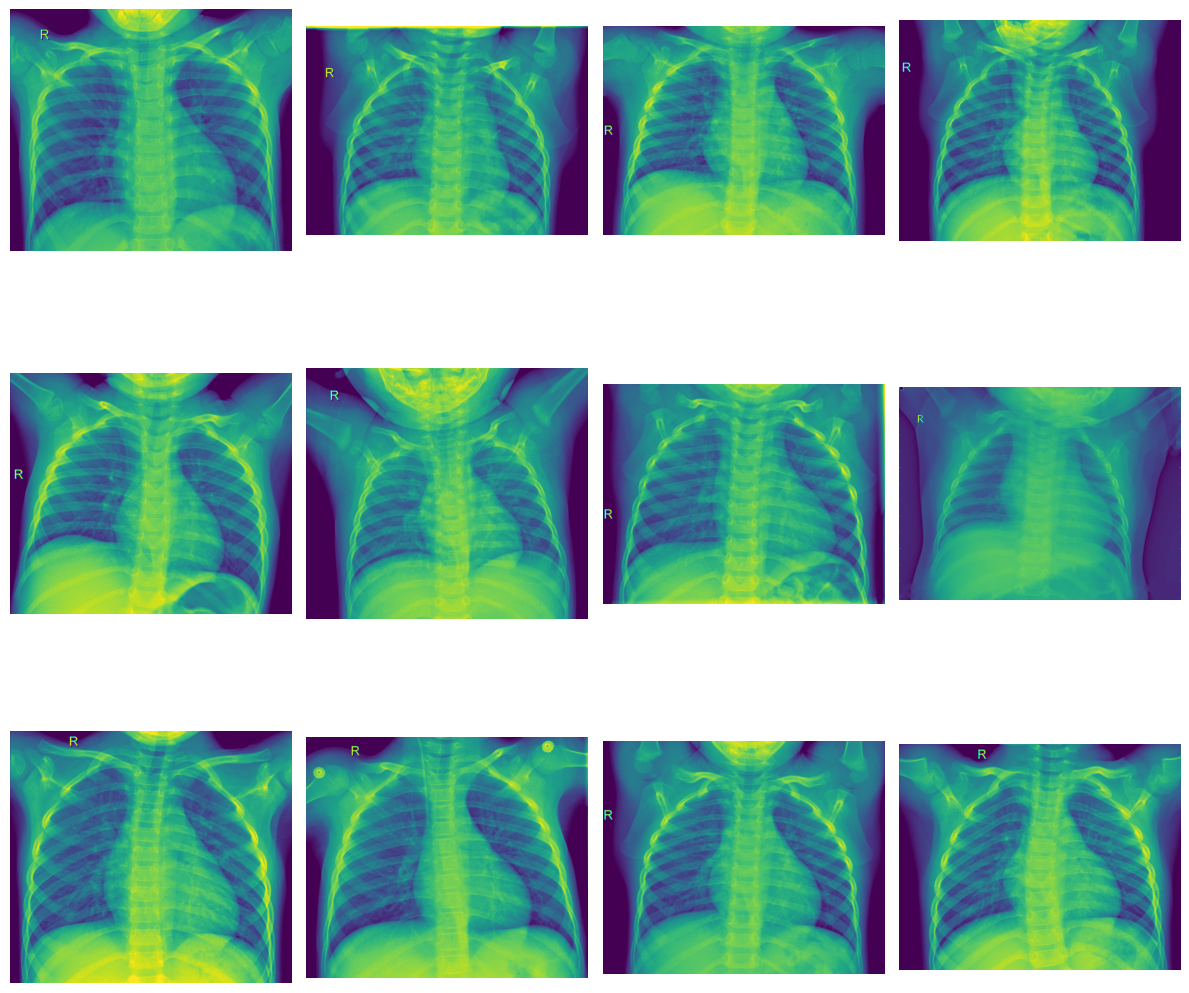

In [6]:
plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_normal[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [6]:
len(df_train)
len(df_test)
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])
len(train_df)
len(val_df)

1044

In [7]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomZoom,RandomTranslation
from tensorflow.keras.layers import RandomBrightness,RandomContrast
class CustomAugmentation(tf.keras.layers.Layer):
    def __init__(self,preprocessing, rotation_factor=0.05,zoom_factor=0.1,translation_factor=0.05,
                 contrast_factor=0.05,brightness_factor=0.05,**kwargs):
        super(CustomAugmentation, self).__init__(**kwargs)
        self.rotation_factor = rotation_factor
        self.rotation_layer = RandomRotation(factor=self.rotation_factor, fill_mode='constant',fill_value=0)
        self.zoom_layer = RandomZoom(height_factor=zoom_factor,fill_mode='constant',fill_value=0)
        self.translation_layer = RandomTranslation(height_factor=translation_factor,width_factor=translation_factor,fill_mode='constant',fill_value=0)
        self.contrast_layer = RandomContrast(factor=contrast_factor)
        self.brightness_layer = RandomBrightness(factor=brightness_factor)
        self.preprocessing = preprocessing
    def call(self, inputs, training=True):
        if training:
            # randomly choose whether to apply the rotation or not
            if tf.random.uniform(()) < 0.7:
                if tf.random.uniform(()) < 0.3:
                    inputs = self.rotation_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.zoom_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.translation_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.contrast_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.brightness_layer(inputs, training=training)

        # if not training or not applying the rotation, return the original image
        return self.preprocessing(inputs)




In [8]:
model_preprocessing = lambda x: tf.keras.applications.vgg19.preprocess_input(x)
## Generate batches of image data (train, validation, and test) with data augmentation
aug = CustomAugmentation(preprocessing=model_preprocessing)
train_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing)#aug.call)
                              
val_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing)
                                    
test_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing) 



ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,)
                                             #seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)
#test_generator.reset()

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

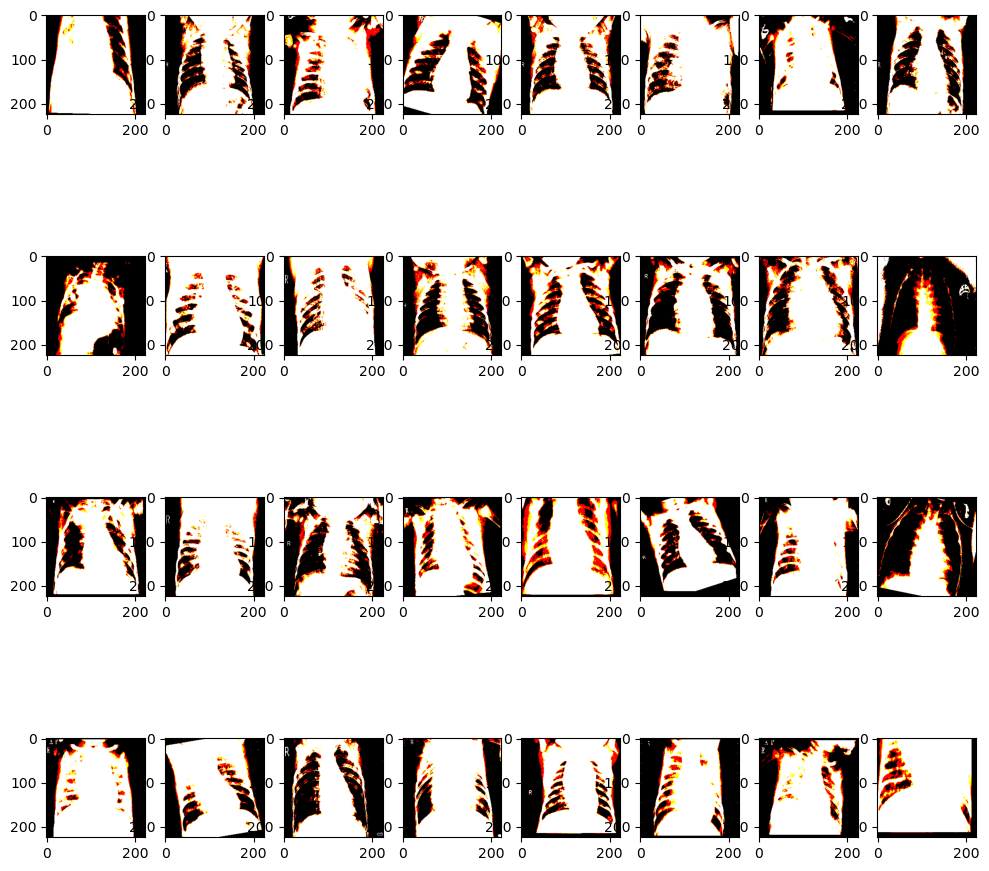

array([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [9]:
plt.figure(figsize=(12,12))
# retrieve a batch of images from the data generator
x_batch, y_batch = next(ds_train)
# plot the first 9 images in the batch
for i in range(32):
    # define subplot
    plt.subplot(4,8,i + 1)
    # plot raw pixel data
    plt.imshow(x_batch[i])
# show the figure
plt.show()
y_batch

In [9]:
from collections import Counter

counter = Counter(ds_train.classes)

print(counter[0])
print(counter[1])
class_weights={0:counter[0]/(counter[0]+counter[1]),1:counter[1]/(counter[0]+counter[1])}
print(class_weights)

1073
3099
{0: 0.2571907957813998, 1: 0.7428092042186002}


In [10]:
 #Set up the VGG19 model
hyper_dimension = 224
hyper_channels = 3
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(hyper_dimension, hyper_dimension, hyper_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific classification task
x = base_model(base_model.input, training = False)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model with an optimizer, loss function, and metrics
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),  loss='binary_crossentropy',  metrics=[Accuracy()])

In [11]:


filepath= "model_cnn1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
e_s = EarlyStopping(monitor='val_loss', patience=20)



In [12]:
# Train the model
vgg19_model= model.fit(ds_train, 
          steps_per_epoch = len(ds_train),
                              epochs = 20, 
                              validation_data = ds_val,
                              validation_steps = len(ds_val), 
                              verbose=1, batch_size=BATCH, callbacks=[checkpoint,e_s],
                              class_weight=class_weights,
                              )

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.6884
Epoch 1: val_loss improved from inf to 0.08016, saving model to model_cnn1.h5
131/131 [==============================] - 1507s 11s/step - loss: 0.2992 - accuracy: 0.6884 - val_loss: 0.0802 - val_accuracy: 0.7011
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.6961
Epoch 2: val_loss did not improve from 0.08016
131/131 [==============================] - 69s 528ms/step - loss: 0.0263 - accuracy: 0.6961 - val_loss: 0.1625 - val_accuracy: 0.7203
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.7081
Epoch 3: val_loss improved from 0.08016 to 0.06642, saving model to model_cnn1.h5
131/131 [==============================] - 77s 586ms/step - loss: 0.0137 - accuracy: 0.7081 - val_loss: 0.0664 - val_accuracy: 0.6935
Epoch 4/20
131/131 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.7157
Epoch 4

In [29]:
best_model = keras.models.load_model(r"C:\Users\nourn\Desktop\post_grad\winter\machine learning\project\pnemonia\code\model_cnn1.h5")
print(best_model.history)

None


In [30]:
def create_charts(cnn, cnn_model,best):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = ds_test.classes
    Y_pred = best.predict_generator(ds_test, steps = len(ds_test))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

[Summary Statistics]
Accuracy = 77.24% | Precision = 73.40% | Recall = 99.74% | Specificity = 39.74% | F1 Score = 84.57%


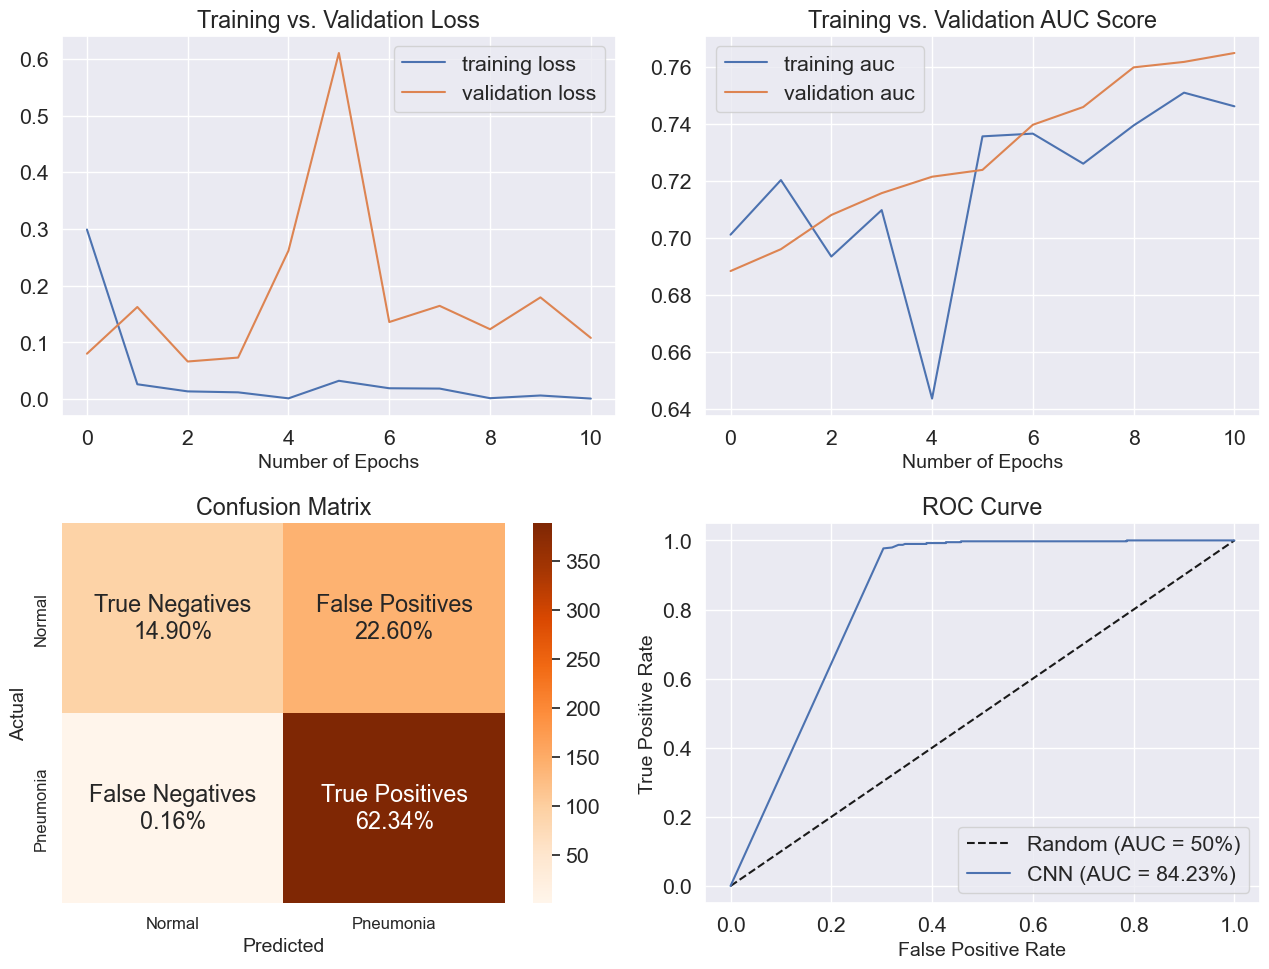

In [31]:
create_charts(model, vgg19_model,best_model)


In [38]:
for layer in base_model.layers[-2:]:
    layer.trainable = True
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     